正在載入資料: data/uci_default_cleaned.csv...
正在訓練 Random Forest 模型...
正在尋找最佳閾值...
最佳閾值 (Recall ~ 0.6): 0.44

--- 最終模型評估 (調整閾值後) ---
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      4667
           1       0.46      0.61      0.53      1326

    accuracy                           0.76      5993
   macro avg       0.67      0.71      0.68      5993
weighted avg       0.79      0.76      0.77      5993

繪製 Confusion Matrix...
已儲存: confusion_matrix_final.png


<Figure size 800x800 with 0 Axes>

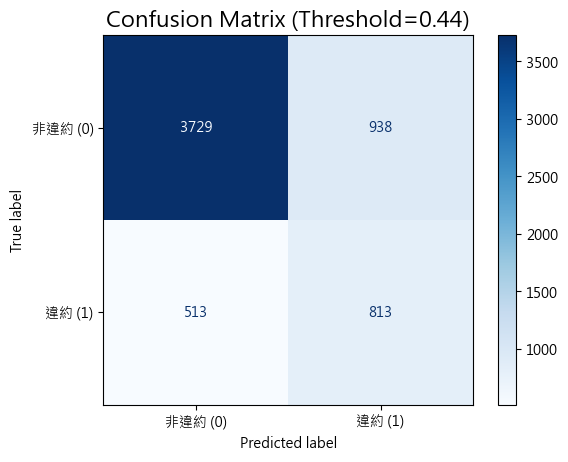

繪製 ROC Curve...
已儲存: roc_curve_final.png


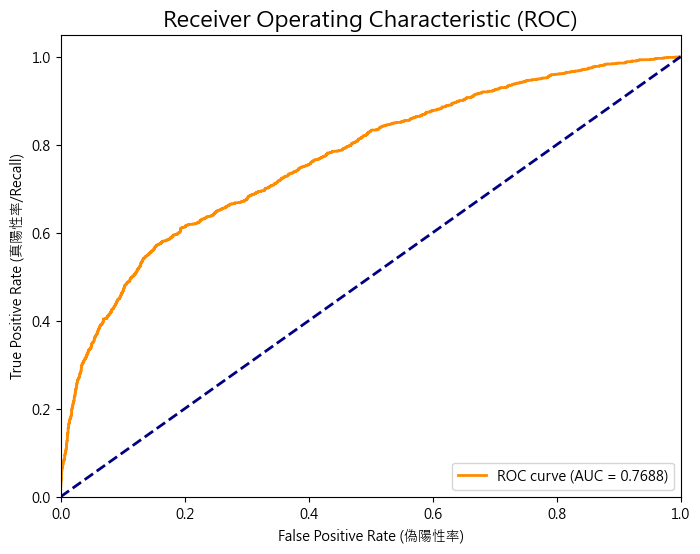


正在計算 SHAP Values...
已儲存: shap_summary_plot.png


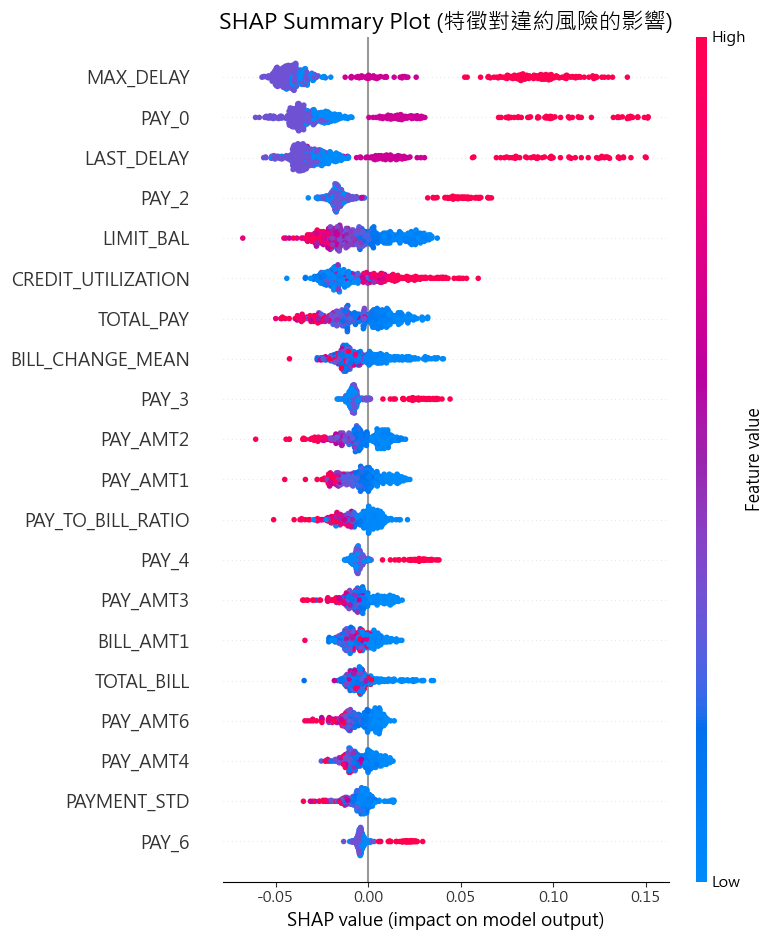

已儲存: shap_importance_bar.png


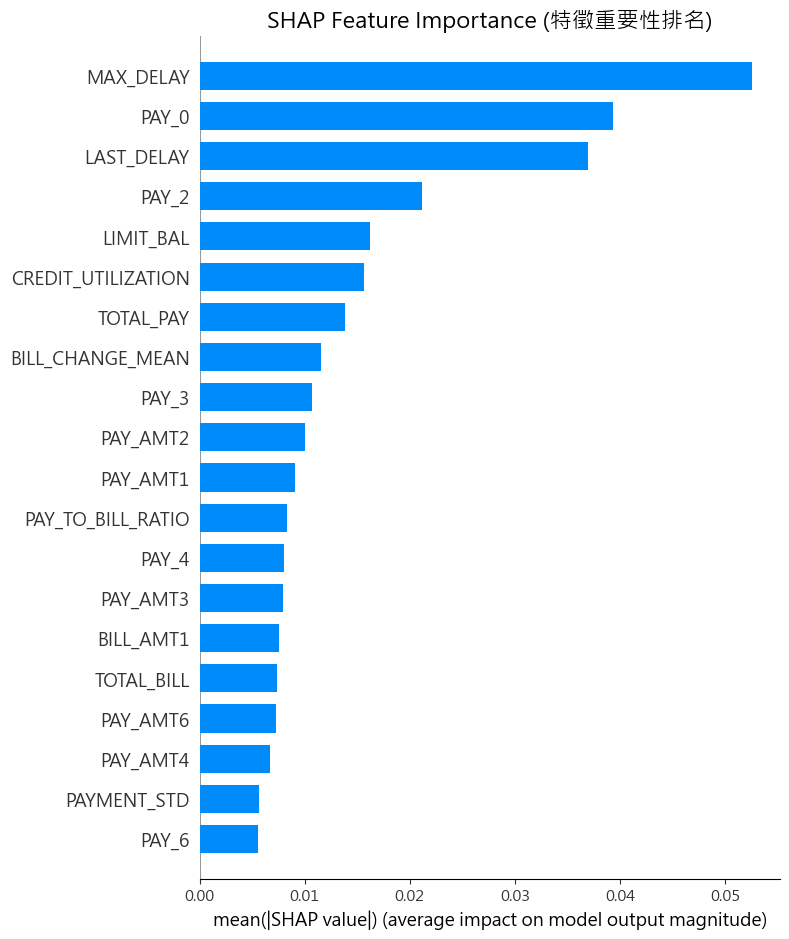


正在進行閾值敏感度分析...
   Threshold    Recall  Precision  Accuracy  F1-Score
0        0.2  0.951735   0.257236  0.381278  0.405006
1        0.3  0.824284   0.321282  0.575838  0.462352
2        0.4  0.658371   0.412961  0.717337  0.507558
3        0.5  0.558069   0.519298  0.787919  0.537986
4        0.6  0.464555   0.569843  0.803938  0.511840
已儲存分析表: threshold_sensitivity_analysis.csv
已儲存比較圖: threshold_comparison.png


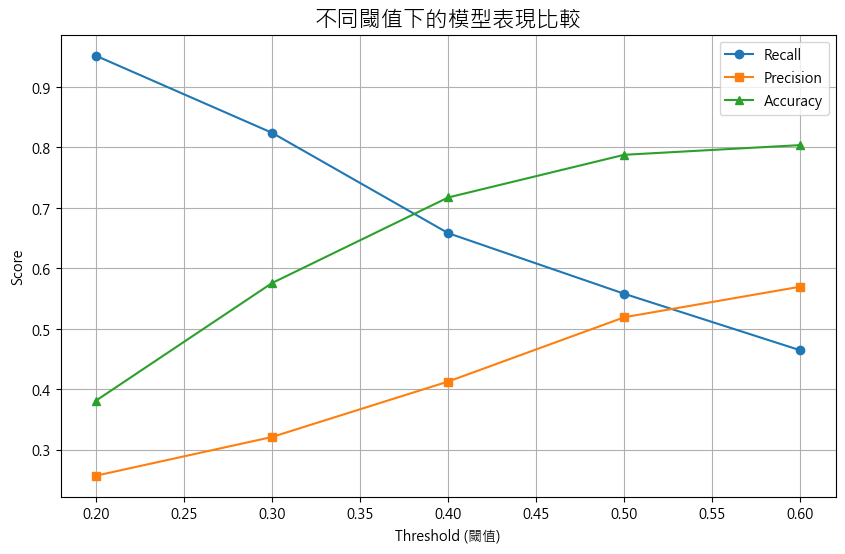

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, recall_score, 
    roc_auc_score, precision_recall_curve, precision_score, 
    accuracy_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay
)

# 設定中文字型 (選用，若圖表中文顯示亂碼可略過或調整)
# 如果在你的環境中中文仍亂碼，請將此兩行註解掉
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False


# 1. 載入資料
file_path = 'data/uci_default_cleaned.csv' 
print(f"正在載入資料: {file_path}...")
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"錯誤：找不到檔案 {file_path}。請確認檔案路徑是否正確。")
    exit()

target = 'default payment next month'
X = df.drop(columns=[target])
y = df[target]

# 2. 切分資料
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. 訓練模型
print("正在訓練 Random Forest 模型...")
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    class_weight='balanced', # 處理資料不平衡
    random_state=42, 
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# 4. 取得預測機率
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# 5. 閾值調整 (找 Recall >= 0.6 的最佳點)
print("正在尋找最佳閾值...")
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
for t in thresholds:
    y_temp_pred = (y_pred_proba >= t).astype(int)
    recall = recall_score(y_test, y_temp_pred)
    if recall < 0.60:
        best_threshold = t - 0.01
        break

print(f"最佳閾值 (Recall ~ 0.6): {best_threshold:.2f}")
y_final_pred = (y_pred_proba >= best_threshold).astype(int)

# 6. 基本評估報告 (使用調整後閾值)
print("\n--- 最終模型評估 (調整閾值後) ---")
print(classification_report(y_test, y_final_pred))


# ==========================================
#  必備圖表生成 (修正版：存檔 + 顯示)
# ==========================================

# 7. Confusion Matrix (混淆矩陣)
print("繪製 Confusion Matrix...")
cm = confusion_matrix(y_test, y_final_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['非違約 (0)', '違約 (1)'])

plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title(f'Confusion Matrix (Threshold={best_threshold:.2f})', fontsize=16)

# 1. 先存檔 (設定 dpi=300 讓圖片高清，適合放 PPT)
plt.savefig('confusion_matrix_final.png', dpi=300, bbox_inches='tight')
print("已儲存: confusion_matrix_final.png")

# 2. 再顯示 (讓你在 Notebook 裡直接看到)
plt.show() 


# 8. ROC Curve (ROC 曲線)
print("繪製 ROC Curve...")
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (偽陽性率)')
plt.ylabel('True Positive Rate (真陽性率/Recall)')
plt.title('Receiver Operating Characteristic (ROC)', fontsize=16)
plt.legend(loc="lower right")

# 存檔 + 顯示
plt.savefig('roc_curve_final.png', dpi=300, bbox_inches='tight')
print("已儲存: roc_curve_final.png")
plt.show()


# ==========================================
#  SHAP Value 分析
# ==========================================
print("\n正在計算 SHAP Values...")

explainer = shap.TreeExplainer(rf_model)
X_test_sample = X_test.iloc[:500] # 僅取前 500 筆加速
shap_values = explainer.shap_values(X_test_sample)

# 取得 Class 1 (違約) 的 SHAP values
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values

# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, show=False)
plt.title("SHAP Summary Plot (特徵對違約風險的影響)", fontsize=16)
plt.tight_layout()

# 存檔 + 顯示
plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
print("已儲存: shap_summary_plot.png")
plt.show()

# SHAP Bar Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (特徵重要性排名)", fontsize=16)
plt.tight_layout()

# 存檔 + 顯示
plt.savefig('shap_importance_bar.png', dpi=300, bbox_inches='tight')
print("已儲存: shap_importance_bar.png")
plt.show()


# ==========================================
#  閾值敏感度分析圖
# ==========================================
print("\n正在進行閾值敏感度分析...")

thresholds_to_test = [0.2, 0.3, 0.4, 0.5, 0.6]
results = []
for t in thresholds_to_test:
    y_temp_pred = (y_pred_proba >= t).astype(int)
    results.append({
        'Threshold': t,
        'Recall': recall_score(y_test, y_temp_pred),
        'Precision': precision_score(y_test, y_temp_pred),
        'Accuracy': accuracy_score(y_test, y_temp_pred),
        'F1-Score': f1_score(y_test, y_temp_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

results_df.to_csv('threshold_sensitivity_analysis.csv', index=False)
print("已儲存分析表: threshold_sensitivity_analysis.csv")

# 畫出折線圖比較
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], marker='o', label='Recall')
plt.plot(results_df['Threshold'], results_df['Precision'], marker='s', label='Precision')
plt.plot(results_df['Threshold'], results_df['Accuracy'], marker='^', label='Accuracy')
plt.xlabel('Threshold (閾值)')
plt.ylabel('Score')
plt.title('不同閾值下的模型表現比較', fontsize=16)
plt.legend()
plt.grid(True)

# 存檔 + 顯示
plt.savefig('threshold_comparison.png', dpi=300, bbox_inches='tight')
print("已儲存比較圖: threshold_comparison.png")
plt.show()